In [1]:
import numpy as np
import sys
import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt


In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
text = text.lower()

In [3]:
class TextGenerator():
    def __init__(self, text, seq_length = 100, shifting = 3):
        self.seq_length = seq_length
        self.shifting = shifting

        self.numeric_text = self.encode(text)
        self.X, self.Y = self.vectorize()
        self.X = np_utils.to_categorical(self.X)
        self.Y = np_utils.to_categorical(self.Y)
        self.model = None


    def encode(self, text):
        chars = sorted(list(set(text)))
        self.char_to_int = dict((c, i) for i, c in enumerate(chars))
        self.int_to_char = np.array(chars)
        self.n_chars = len(text)
        self.n_vocab = len(chars)
        self.mapping = lambda x: self.char_to_int[x]
        self.inverse_mapping = lambda x: self.int_to_char[x]
        numeric_text = np.asarray(list(map(self.mapping, text)))
        return numeric_text
    
    def vectorize(self):
        X = []
        Y = []
        for i in range(0, self.n_chars - self.seq_length, self.shifting):
            X.append(self.numeric_text[i:i + self.seq_length])
            Y.append(self.numeric_text[i + self.seq_length])
        self.n_patterns = len(X)
        X = np.reshape(X, (self.n_patterns, self.seq_length))
        return X,Y


    def build_model(self, rnn_size):
        model = Sequential()
        model.add(self.recurrent_layer(rnn_size, input_shape=(self.seq_length, self.n_vocab), return_sequences=True))
        model.add(self.recurrent_layer(rnn_size))
        model.add(Dropout(0.2))
        model.add(Dense(self.Y.shape[-1], activation='softmax'))
        model.compile(loss=self.lossfunc, optimizer=self.optimizer, metrics = 'accuracy')
        return model
        # model.summary()



    def train(self, recurrent_layer, optimizer, lossfunc, n_units, batch_size, n_epochs):
        t0 = time.time()
        if recurrent_layer == 'GRU':
            self.recurrent_layer = GRU
        elif recurrent_layer == 'LSTM':
            self.recurrent_layer = LSTM
        elif recurrent_layer == 'RNN':
            self.recurrent_layer = SimpleRNN
        else:
            raise ValueError('Unknown recurrent layer')

        self.optimizer = optimizer
        self.lossfunc = lossfunc
        self.model = self.build_model(n_units)
        trained_model = self.model.fit(self.X, self.Y, epochs=n_epochs, batch_size=batch_size,  validation_split=0.2)
        self.plot(trained_model)
        t = time.time()
        print(f'training time: {round(t - t0, 2)}s')




    def sample(self, pred):
        preds = pred.ravel()
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / self.temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        return np.argmax(probas)
        # return np.random.choice(len(preds), p=preds)

    def plot(self,TrainedModel):
        history = TrainedModel
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.grid()
        plt.show()


    def generate_text(self, n_pred, temperature):
        self.temperature = temperature
        len = self.n_patterns - self.seq_length -1
        start = np.random.randint(0, len)
        sentence = self.X[start]
        seed = np.argmax(sentence, axis=1)
        seed = ''.join([self.int_to_char[value][0] for value in seed])
        generated = ''
        print(f'seed:\n{seed}')
        print('\nGenerated Text:')
        for i in range(n_pred):
            prediction = self.model.predict(sentence.reshape(1, self.seq_length, self.n_vocab))
            index = self.sample(prediction)
            next_char = self.int_to_char[index]
            one_hot = np.zeros([self.n_vocab, 1])
            one_hot[index] = 1
            sentence = np.concatenate([sentence[1:], one_hot.T], axis=0)
            generated += next_char
            sys.stdout.write(next_char)
            sys.stdout.flush()
            self.generated = generated
        return generated

    def remove_model(self):
        if self.model:
            del self.model

     


# **3**

In [ ]:
def vectorize(numeric_text,  n_chars, seq_length, shifting):
    X = []
    Y = []
    for i in range(0, n_chars - seq_length, shifting):
        X.append(numeric_text[i:i + seq_length])
        Y.append(numeric_text[i + seq_length])
    n_patterns = len(X)
    X = np.reshape(X, (n_patterns, seq_length))
    Y = np.asarray(Y)
    return X,Y

chars = sorted(list(set(text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = np.array(chars)
n_chars = len(text)
n_vocab = len(chars)
mapping = lambda x: char_to_int[x]
inverse_mapping = lambda x: int_to_char[x]
numeric_text = np.asarray(list(map(mapping, text)))


In [ ]:
seq_length = 100
shifting = 3
X,Y = vectorize(numeric_text,  n_chars, seq_length, shifting)

idx = np.random.randint(X.shape[0])
seed = X[idx]
target = int_to_char[Y[idx]]
input = ''.join([int_to_char[value][0] for value in seed])
print(f'input:\n{input}\ntarget: {target}')

seed = X[idx+1]
target = int_to_char[Y[idx+1]]
input = ''.join([int_to_char[value][0] for value in seed])
print(f'\nnext input:\n{input}\ntarget: {target}')

input:
herd's homely curds,
his cold thin drink out of his leather bottle.
his wonted sleep under a fresh t
target: r

next input:
d's homely curds,
his cold thin drink out of his leather bottle.
his wonted sleep under a fresh tree
target: '


In [ ]:
seq_length = 30
shifting = 1
X,Y = vectorize(numeric_text,  n_chars, seq_length, shifting)

idx = np.random.randint(X.shape[0])
seed = X[idx]
target = int_to_char[Y[idx]]
input = ''.join([int_to_char[value][0] for value in seed])
print(f'input:\n{input}\ntarget: {target}')

seed = X[idx+1]
target = int_to_char[Y[idx+1]]
input = ''.join([int_to_char[value][0] for value in seed])
print(f'\nnext input:\n{input}\ntarget: {target}')

input:
fs manifold and sorceries terr
target: i

next input:
s manifold and sorceries terri
target: b


In [ ]:
seq_length = 500
shifting = 10
X,Y = vectorize(numeric_text,  n_chars, seq_length, shifting)

idx = np.random.randint(X.shape[0])
seed = X[idx]
target = int_to_char[Y[idx]]
input = ''.join([int_to_char[value][0] for value in seed])
print(f'input:\n{input}\ntarget: {target}')

seed = X[idx+1]
target = int_to_char[Y[idx+1]]
input = ''.join([int_to_char[value][0] for value in seed])
print(f'\nnext input:\n{input}\ntarget: {target}')

input:
 we are shent for keeping your
greatness back?

second senator:
what cause, do you think, i have to swoon?

menenius:
i neither care for the world nor your general: for
such things as you, i can scarce think there's any,
ye're so slight. he that hath a will to die by
himself fears it not from another: let your general
do his worst. for you, be that you are, long; and
your misery increase with your age! i say to you,
as i was said to, away!

first senator:
a noble fellow, i warrant him.

second s
target: e

next input:
ent for keeping your
greatness back?

second senator:
what cause, do you think, i have to swoon?

menenius:
i neither care for the world nor your general: for
such things as you, i can scarce think there's any,
ye're so slight. he that hath a will to die by
himself fears it not from another: let your general
do his worst. for you, be that you are, long; and
your misery increase with your age! i say to you,
as i was said to, away!

first senator:
a noble fellow, i w

# **7**

In [4]:
text_generator = TextGenerator(text)

Epoch 1/15
1162/1162 [==============================] - 40s 27ms/step - loss: 2.7595 - accuracy: 0.2309 - val_loss: 2.1362 - val_accuracy: 0.3720
Epoch 2/15
1162/1162 [==============================] - 31s 26ms/step - loss: 2.0569 - accuracy: 0.3991 - val_loss: 1.9541 - val_accuracy: 0.4125
Epoch 3/15
1162/1162 [==============================] - 31s 27ms/step - loss: 1.8706 - accuracy: 0.4439 - val_loss: 1.8528 - val_accuracy: 0.4416
Epoch 4/15
1162/1162 [==============================] - 31s 27ms/step - loss: 1.7566 - accuracy: 0.4726 - val_loss: 1.8020 - val_accuracy: 0.4576
Epoch 5/15
1162/1162 [==============================] - 31s 27ms/step - loss: 1.6798 - accuracy: 0.4937 - val_loss: 1.7694 - val_accuracy: 0.4704
Epoch 6/15
1162/1162 [==============================] - 31s 27ms/step - loss: 1.6229 - accuracy: 0.5080 - val_loss: 1.7354 - val_accuracy: 0.4764
Epoch 7/15
1162/1162 [==============================] - 32s 27ms/step - loss: 1.5695 - accuracy: 0.5213 - val_loss: 1.7103 -

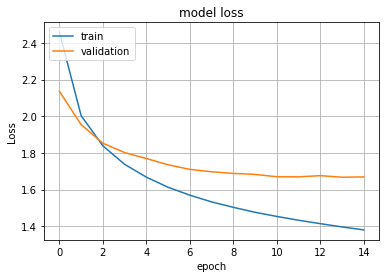

training time: 490.69s


In [ ]:
layer = 'LSTM'
optimizer = 'rmsprop'
lossfunc = 'categorical_crossentropy'
text_generator.train(layer, optimizer, lossfunc, n_units = 128, batch_size = 256, n_epochs = 15)

In [ ]:
pred = text_generator.generate_text(n_pred = 300, temperature=0.2)

seed:
ispering tale in a fair lady's ear,
such as would please: 'tis gone, 'tis gone, 'tis gone:
you are w

Generated Text:
ords in the country's death with him,
and the strength of the blood of his consent
the bloody soul with a seeming of the counsel,
the strenger of my soul in a man and heart
to see the common to the capitol'd the counter
than the strength of mine one to me to thee.

camillo:
i have been beholding hea

Epoch 1/15
1162/1162 [==============================] - 33s 26ms/step - loss: 0.0229 - accuracy: 0.2169 - val_loss: 0.0199 - val_accuracy: 0.3570
Epoch 2/15
1162/1162 [==============================] - 31s 27ms/step - loss: 0.0194 - accuracy: 0.3839 - val_loss: 0.0189 - val_accuracy: 0.3985
Epoch 3/15
1162/1162 [==============================] - 32s 27ms/step - loss: 0.0183 - accuracy: 0.4219 - val_loss: 0.0183 - val_accuracy: 0.4186
Epoch 4/15
1162/1162 [==============================] - 32s 27ms/step - loss: 0.0175 - accuracy: 0.4491 - val_loss: 0.0179 - val_accuracy: 0.4325
Epoch 5/15
1162/1162 [==============================] - 31s 27ms/step - loss: 0.0169 - accuracy: 0.4687 - val_loss: 0.0176 - val_accuracy: 0.4467
Epoch 6/15
1162/1162 [==============================] - 31s 27ms/step - loss: 0.0164 - accuracy: 0.4867 - val_loss: 0.0172 - val_accuracy: 0.4565
Epoch 7/15
1162/1162 [==============================] - 31s 27ms/step - loss: 0.0161 - accuracy: 0.4979 - val_loss: 0.0171 -

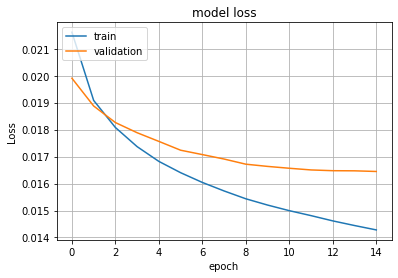

training time: 471.88s


In [ ]:
text_generator.remove_model()
layer = 'LSTM'
optimizer = 'rmsprop'
lossfunc = 'mse'
text_generator.train(layer, optimizer, lossfunc, n_units = 128, batch_size = 256, n_epochs = 15)

In [ ]:
pred = text_generator.generate_text(n_pred = 300, temperature=0.2)

seed:
mmon
of the whole body. the belly answer'd--

first citizen:
well, sir, what answer made the belly?


Generated Text:

gloucester:
it is the send in the companse the crown,
and the rest the death of the beart of the comes
and the lord and the are and to the harpers.

buckingham:
if thou shalt he that the hard and the man and the
world should be so to the traitor of the part of here.

king richard iii:
what shall be

Epoch 1/15
1162/1162 [==============================] - 35s 28ms/step - loss: 2.7831 - accuracy: 0.2282 - val_loss: 2.1138 - val_accuracy: 0.3772
Epoch 2/15
1162/1162 [==============================] - 32s 27ms/step - loss: 2.0428 - accuracy: 0.3999 - val_loss: 1.9324 - val_accuracy: 0.4162
Epoch 3/15
1162/1162 [==============================] - 31s 27ms/step - loss: 1.8593 - accuracy: 0.4467 - val_loss: 1.8459 - val_accuracy: 0.4415
Epoch 4/15
1162/1162 [==============================] - 32s 27ms/step - loss: 1.7442 - accuracy: 0.4768 - val_loss: 1.7844 - val_accuracy: 0.4632
Epoch 5/15
1162/1162 [==============================] - 32s 27ms/step - loss: 1.6628 - accuracy: 0.4989 - val_loss: 1.7480 - val_accuracy: 0.4711
Epoch 6/15
1162/1162 [==============================] - 32s 27ms/step - loss: 1.6086 - accuracy: 0.5133 - val_loss: 1.7207 - val_accuracy: 0.4843
Epoch 7/15
1162/1162 [==============================] - 32s 27ms/step - loss: 1.5584 - accuracy: 0.5266 - val_loss: 1.6964 -

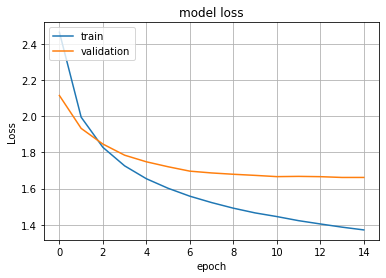

training time: 477.31s


In [ ]:
text_generator.remove_model()
layer = 'LSTM'
optimizer = 'Adam'
lossfunc = 'categorical_crossentropy'
text_generator.train(layer, optimizer, lossfunc, n_units = 128, batch_size = 256, n_epochs = 15)

In [ ]:
pred = text_generator.generate_text(n_pred = 300, temperature=0.2)

seed:
 were putting to my house the brand
that should consume it, i have not the face
to say 'beseech you,

Generated Text:
 that i have speak the castle,
that i shall stand the words and the world to the propest,
and stay the hand the consent have sour thing that he
had the courtess and the crown of the country's brother.

king richard iii:
what should the best than the country's from the live,
and then the son of the w

# **8**

Epoch 1/15
1162/1162 [==============================] - 36s 24ms/step - loss: 2.5653 - accuracy: 0.2787 - val_loss: 1.9971 - val_accuracy: 0.4019
Epoch 2/15
1162/1162 [==============================] - 27s 23ms/step - loss: 1.9286 - accuracy: 0.4254 - val_loss: 1.8466 - val_accuracy: 0.4481
Epoch 3/15
1162/1162 [==============================] - 27s 24ms/step - loss: 1.7669 - accuracy: 0.4731 - val_loss: 1.7822 - val_accuracy: 0.4639
Epoch 4/15
1162/1162 [==============================] - 27s 23ms/step - loss: 1.6797 - accuracy: 0.4947 - val_loss: 1.7408 - val_accuracy: 0.4779
Epoch 5/15
1162/1162 [==============================] - 27s 23ms/step - loss: 1.6216 - accuracy: 0.5090 - val_loss: 1.7145 - val_accuracy: 0.4851
Epoch 6/15
1162/1162 [==============================] - 27s 23ms/step - loss: 1.5741 - accuracy: 0.5226 - val_loss: 1.6987 - val_accuracy: 0.4925
Epoch 7/15
1162/1162 [==============================] - 27s 23ms/step - loss: 1.5375 - accuracy: 0.5316 - val_loss: 1.6811 -

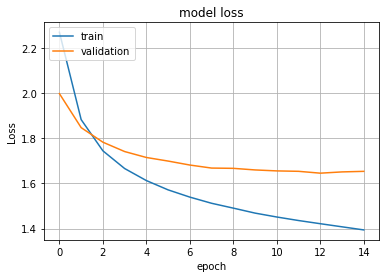

training time: 418.87s


In [5]:
text_generator.remove_model()
layer = 'GRU'
optimizer = 'adam'
lossfunc = 'categorical_crossentropy'
text_generator.train(layer, optimizer, lossfunc, n_units = 128, batch_size = 256, n_epochs = 15)

In [6]:
pred = text_generator.generate_text(n_pred = 200, temperature=0.2)

seed:
at then remains, we being thus arrived
from ravenspurgh haven before the gates of york,
but that we 

Generated Text:
will be so properts to the world
than the world of the perise to my father,
that the father with the counsels of your house,
to the man to the world be so much rest;
and there so much rest the people,

Epoch 1/15
1162/1162 [==============================] - 155s 131ms/step - loss: 2.6257 - accuracy: 0.2675 - val_loss: 2.1822 - val_accuracy: 0.3513
Epoch 2/15
1162/1162 [==============================] - 153s 132ms/step - loss: 2.1358 - accuracy: 0.3736 - val_loss: 2.0446 - val_accuracy: 0.3937
Epoch 3/15
1162/1162 [==============================] - 149s 128ms/step - loss: 2.0124 - accuracy: 0.4063 - val_loss: 1.9662 - val_accuracy: 0.4143
Epoch 4/15
1162/1162 [==============================] - 150s 129ms/step - loss: 1.9359 - accuracy: 0.4273 - val_loss: 1.9301 - val_accuracy: 0.4247
Epoch 5/15
1162/1162 [==============================] - 149s 128ms/step - loss: 1.8797 - accuracy: 0.4433 - val_loss: 1.8871 - val_accuracy: 0.4357
Epoch 6/15
1162/1162 [==============================] - 152s 131ms/step - loss: 1.8393 - accuracy: 0.4543 - val_loss: 1.8589 - val_accuracy: 0.4445
Epoch 7/15
1162/1162 [==============================] - 150s 129ms/step - loss: 1.7979 - accuracy: 0.4655 - val_

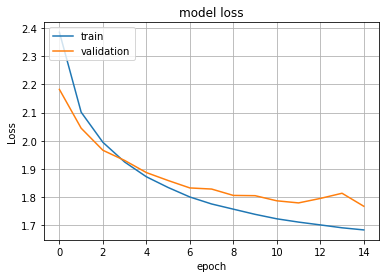

training time: 2270.83s


In [ ]:
text_generator.remove_model()
layer = 'RNN'
optimizer = 'adam'
lossfunc = 'categorical_crossentropy'
text_generator.train(layer, optimizer, lossfunc, n_units = 128, batch_size = 256, n_epochs = 15)

In [ ]:
pred = text_generator.generate_text(n_pred = 200, temperature=0.2)

seed:
urderer:
what shall we do?

clarence:
relent, and save your souls.

first murderer:
relent! 'tis cow

Generated Text:
ill to the bear the heart the heart,
and the world the hath the brother that we will the words
the coust in my hand the warwick the hand the some of his arment.

gloucester:
what in the stard the stan

Epoch 1/15
1162/1162 [==============================] - 30s 24ms/step - loss: 2.5510 - accuracy: 0.2825 - val_loss: 2.0475 - val_accuracy: 0.3900
Epoch 2/15
1162/1162 [==============================] - 27s 23ms/step - loss: 1.9865 - accuracy: 0.4098 - val_loss: 1.8912 - val_accuracy: 0.4281
Epoch 3/15
1162/1162 [==============================] - 27s 23ms/step - loss: 1.8158 - accuracy: 0.4581 - val_loss: 1.8058 - val_accuracy: 0.4571
Epoch 4/15
1162/1162 [==============================] - 27s 23ms/step - loss: 1.7199 - accuracy: 0.4821 - val_loss: 1.7664 - val_accuracy: 0.4674
Epoch 5/15
1162/1162 [==============================] - 27s 23ms/step - loss: 1.6517 - accuracy: 0.5027 - val_loss: 1.7280 - val_accuracy: 0.4788
Epoch 6/15
1162/1162 [==============================] - 27s 23ms/step - loss: 1.6011 - accuracy: 0.5153 - val_loss: 1.6977 - val_accuracy: 0.4871
Epoch 7/15
1162/1162 [==============================] - 27s 23ms/step - loss: 1.5645 - accuracy: 0.5256 - val_loss: 1.6872 -

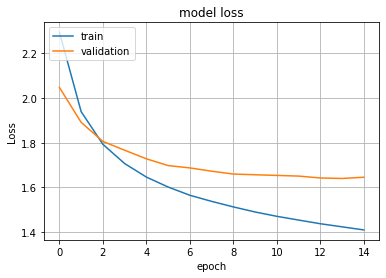

training time: 406.88s


In [7]:
text_generator.remove_model()
layer = 'GRU'
optimizer = 'rmsprop'
lossfunc = 'categorical_crossentropy'
text_generator.train(layer, optimizer, lossfunc, n_units = 128, batch_size = 256, n_epochs = 15)

In [19]:
pred = text_generator.generate_text(n_pred = 200, temperature=0.2)

seed:
oucester:
what, will the aspiring blood of lancaster
sink in the ground? i thought it would have mou

Generated Text:
th,
and let me so should be the sent the better to makes
the looks the more to see him to be so me to good
when i have seed the state the earth, and i will be gone.

king richard iii:
a man and my lor

# ***9***


In [ ]:
text_generator = TextGenerator(text, seq_length=80, shifting=2)

Epoch 1/50
1743/1743 [==============================] - 90s 51ms/step - loss: 2.5442 - accuracy: 0.2801 - val_loss: 1.8668 - val_accuracy: 0.4361
Epoch 2/50
1743/1743 [==============================] - 87s 50ms/step - loss: 1.7320 - accuracy: 0.4793 - val_loss: 1.7090 - val_accuracy: 0.4865
Epoch 3/50
1743/1743 [==============================] - 87s 50ms/step - loss: 1.5484 - accuracy: 0.5270 - val_loss: 1.6430 - val_accuracy: 0.5039
Epoch 4/50
1743/1743 [==============================] - 87s 50ms/step - loss: 1.4512 - accuracy: 0.5537 - val_loss: 1.6110 - val_accuracy: 0.5154
Epoch 5/50
1743/1743 [==============================] - 87s 50ms/step - loss: 1.3816 - accuracy: 0.5713 - val_loss: 1.5913 - val_accuracy: 0.5236
Epoch 6/50
1743/1743 [==============================] - 87s 50ms/step - loss: 1.3315 - accuracy: 0.5854 - val_loss: 1.5939 - val_accuracy: 0.5264
Epoch 7/50
1743/1743 [==============================] - 87s 50ms/step - loss: 1.2857 - accuracy: 0.5971 - val_loss: 1.5788 -

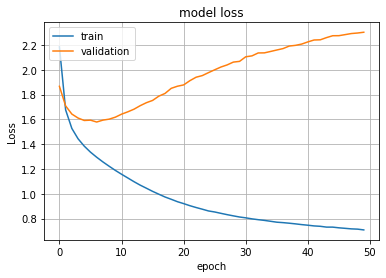

training time: 4339.36s


In [ ]:
layer = 'LSTM'
optimizer = 'adam'
lossfunc = 'categorical_crossentropy'
text_generator.train(layer, optimizer, lossfunc, n_units = 256, batch_size = 256, n_epochs = 50)

In [ ]:
pred = text_generator.generate_text(n_pred = 300, temperature=0.2)

seed:
from out my heart;
with mine own tears i wash away my balm,
with mine own hands 

Generated Text:
and prayers and was said 'bring,
but whom my honour with my dispresent
that i would fall one honour on his head;
and when i have, bid my brother here,
that thou shalt do it the heavenles trives and dangs;
and with thy father, though it not on him.

duke of aumerle:
stay, but yet shall be so much don